In [6]:
# All imports here
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dropout, TimeDistributed, Dense, Activation, Embedding
from datetime import datetime
import matplotlib.pyplot as plt

In [7]:
BATCH_SIZE = 16
SEQUENCE_LENGTH = 64

In [8]:
# Path to the input data directory
input_data_dir = "/content/drive/MyDrive/NeuralNets/Project/data/"
char_to_idx_fname = "char_to_index.json"

train_data_path = input_data_dir + "train.npy"
label_data_path = input_data_dir + "labels.npy"
trained_model_weight_path = input_data_dir + "trained_gru.h5"

In [9]:
char_to_index = json.load(open(input_data_dir + char_to_idx_fname))
index_to_char = { i: ch for ch, i in char_to_index.items() }
VOCAB_SIZE = len(char_to_index)
print("Char to index mapping size: ", VOCAB_SIZE)

Char to index mapping size:  93


In [11]:
# Get the data and labels from files
data = np.load(train_data_path)
labels = np.load(label_data_path)
print(data.shape, labels.shape)

(441, 16, 64) (441, 16, 64, 93)


In [12]:
# Build GRU models
def build_gru(batch_size, seq_length, vocab_size):
  gru = Sequential()
  gru.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_length)))
  gru.add(GRU(256, return_sequences=True, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(GRU(256, return_sequences=True, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(GRU(256, return_sequences=True, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(TimeDistributed(Dense(vocab_size))) 
  gru.add(Activation("softmax"))

  gru.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  gru.summary()
  return gru

def build_gru_predictor(vocab_size):
  gru = Sequential()
  gru.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
  gru.add(GRU(256, return_sequences=True, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(GRU(256, return_sequences=True, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(GRU(256, return_sequences=False, stateful=True))
  gru.add(Dropout(0.2))
  gru.add(Dense(vocab_size, activation="softmax"))
  return gru

In [13]:
def plot_util(values, xlabel, ylabel, title):
  plt.plot(range(len(values)), values)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [14]:
gru_model = build_gru(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (16, 64, 512)             47616     
                                                                 
 gru (GRU)                   (16, 64, 256)             591360    
                                                                 
 dropout (Dropout)           (16, 64, 256)             0         
                                                                 
 gru_1 (GRU)                 (16, 64, 256)             394752    
                                                                 
 dropout_1 (Dropout)         (16, 64, 256)             0         
                                                                 
 gru_2 (GRU)                 (16, 64, 256)             394752    
                                                                 
 dropout_2 (Dropout)         (16, 64, 256)             0

In [15]:
# Helper for Train the model
def train_model(epochs, data, labels, model):
  avg_loss, avg_accuracy = [], []
  for epoch in range(epochs):

    losses, metrics = [], []
    start = datetime.now()

    # Train on all the batches for a single epoch
    for idx, X in enumerate(data):
      cur_loss, cur_acc = model.train_on_batch(X, labels[idx])
      losses.append(cur_loss)
      metrics.append(cur_acc)
    
    # Average loss and accuracy per epoch
    print(f"Epoch {epoch} : Average loss {np.mean(losses)}, Average accuracy {np.mean(metrics)}")
    avg_loss.append(np.mean(losses))
    avg_accuracy.append(np.mean(metrics))

    if (epoch+1)%10==0:
      print(f"Completed epochs : {epoch+1}")
    
  total_time_taken = datetime.now() - start
  
  return avg_loss, avg_accuracy, total_time_taken

In [16]:
losses, metrics, total_time_taken = train_model(100, data, labels, gru_model)

Epoch 0 : Average loss 1.777946823308257, Average accuracy 0.5015656001984127
Epoch 1 : Average loss 1.1810098189074978, Average accuracy 0.6352306547619048
Epoch 2 : Average loss 1.0662751976324587, Average accuracy 0.6668947526927438
Epoch 3 : Average loss 1.000090468902977, Average accuracy 0.6865920847505669
Epoch 4 : Average loss 0.9555843576552376, Average accuracy 0.6995044111394558
Epoch 5 : Average loss 0.9229903137332458, Average accuracy 0.709343112244898
Epoch 6 : Average loss 0.8951084402953686, Average accuracy 0.7172021152210885
Epoch 7 : Average loss 0.8731946212634478, Average accuracy 0.7234955179988662
Epoch 8 : Average loss 0.8540545264068915, Average accuracy 0.7290736607142857
Epoch 9 : Average loss 0.8364774463128071, Average accuracy 0.7347603103741497
Completed epochs : 10
Epoch 10 : Average loss 0.8221213954105939, Average accuracy 0.7377542162698413
Epoch 11 : Average loss 0.8082842278102088, Average accuracy 0.7422605761054422
Epoch 12 : Average loss 0.79490

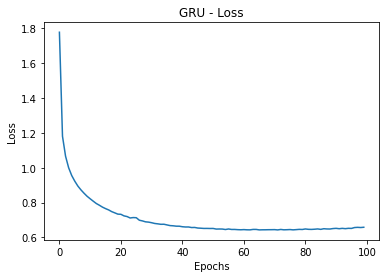

In [17]:
plot_util(losses, 'Epochs', 'Loss', 'GRU - Loss')

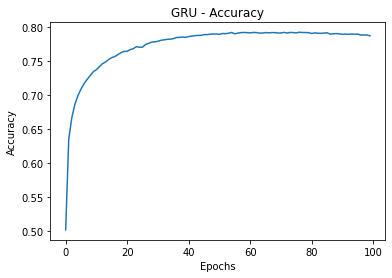

In [18]:
plot_util(metrics, 'Epochs', 'Accuracy', 'GRU - Accuracy')

In [19]:
print(f'The total time taken to train the GRU model is {total_time_taken}')

The total time taken to train the GRU model is 0:00:09.563585


In [20]:
# save the model weights
gru_model.save(trained_model_weight_path)

In [21]:
# Generate music
def generate_music(length, model):

  sampled = []

  for i in range(length):
      batch = np.zeros((1, 1))

      if len(sampled)>0:
        batch[0, 0] = sampled[-1]
      else:
        batch[0, 0] = np.random.randint(VOCAB_SIZE)
      result = model.predict_on_batch(batch).ravel()
      sample = np.random.choice(range(VOCAB_SIZE), p=result)
      sampled.append(sample)

  return ''.join(index_to_char[c] for c in sampled)

In [22]:
# Build the predictor
predictor = build_gru_predictor(VOCAB_SIZE)
predictor.load_weights(trained_model_weight_path)

In [ ]:
output1 = generate_music(1024, predictor)

In [ ]:
print(output1)

In [ ]:
output2 = generate_music(1024, predictor)

In [ ]:
print(output2)

In [ ]:
output3 = generate_music(1024, predictor)

In [ ]:
print(output3)